In [1]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#import random
#import seaborn as sns

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import matplotlib
import scipy

# remap cluster

In [18]:
def get_hg_rate(atac_bed):
	# atac bed
	bc_count={}
	bc_hgrate={}
	with open(atac_bed) as input:
		for line in input:
			items=line.strip().split()
			species=items[0].split('_')[0]
			bc=items[3]
			bc_count.setdefault(bc,[0,0]) # bc: [hg_count, total_count]
			bc_count[bc][1]+=1
			if species=='hg':
				bc_count[bc][0]+=1
	for bc in bc_count.keys():
		bc_hgrate[bc]=bc_count[bc][0]/bc_count[bc][1]
	return bc_hgrate
def get_peak_cor(ref_peak_counts_dict,bc_peak_count_dict):
	peak_count_cor={}
	peaks=inter_peak['peak'].unique()
	bc_all=inter_peak['barcode'].unique()
	NA_bc=[]
	for bc in bc_all:
		bc_count=[]
		ref_count=[]
		for peak in peaks:
			if (bc, peak) in bc_peak_count_dict.keys():
				bc_count.append(bc_peak_count_dict[(bc,peak)])
				ref_count.append(ref_peak_counts_dict[peak])
		cor, pval=scipy.stats.pearsonr(np.log2(np.array(bc_count)+1), np.log2(np.array(ref_count)+1))
		if len(bc_count)<100:
			NA_bc.append(bc)
		peak_count_cor[bc]=cor
	return peak_count_cor, NA_bc

def plot_map(x,y,z,title,figname):
    # z is color map
    cmap = matplotlib.cm.get_cmap('viridis').reversed()
    normalize = matplotlib.colors.Normalize(min(z), max(z))
    colors = [cmap(normalize(value)) for value in z]

    fig, ax = plt.subplots(figsize=(9,6))
    ax.scatter(x, y, color=colors, alpha=0.6,s=8)

    plt.xlabel('Dim 1', fontsize=12)
    plt.ylabel('Dim 2', fontsize=12)
    plt.title(title)
    # Optionally add a colorbar
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
    plt.savefig(figname)
    
def plot_map_NA(x,y,z,title,figname,NA_x,NA_y):
    cmap = matplotlib.cm.get_cmap('YlGnBu')
    normalize = matplotlib.colors.Normalize(min(z), max(z))
    colors = [cmap(normalize(value)) for value in z]

    fig, ax = plt.subplots(figsize=(9,6))
    ax.scatter(x, y, color=colors, alpha=0.6,s=8)

    plt.xlabel('Dim 1', fontsize=12)
    plt.ylabel('Dim 2', fontsize=12)
    plt.title(title)
    # Optionally add a colorbar
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
    ax.scatter(NA_x, NA_y, c='grey', alpha=0.6,s=8)
    plt.savefig(figname)

def map_human_rate(cluster_df, bc_hgrate, name):
    bc_all=cluster_df['barcodes']
    cluster_df['hg_rate']=[bc_hgrate[bc] for bc in bc_all]
    plot_map(cluster_df['tsne.1'], cluster_df['tsne.2'],cluster_df['hg_rate'],'Human rate',name+'_HumanRate.pdf')

def map_peak_cor(cluster_df,peak_cor,name,NA_bc):
    bc_all=cluster_df['barcodes']
    cor=[]
    for bc in bc_all:
        if bc in peak_cor:
            cor.append(peak_cor[bc])
        else:
            cor.append(0)
            NA_bc.append(bc)
    
    NA_df=cluster_df[cluster_df['barcodes'].isin(NA_bc)]
    plot_map_NA(cluster_df['tsne.1'], cluster_df['tsne.2'],cor,'Peak correlation',name+'_PeakCor.pdf',NA_df['tsne.1'],NA_df['tsne.2'])
    

In [8]:
prefix='BinLsa'
sample=ZJS190808
indir='/Share2/home/zhangqf5/yanqiu/scAR/output/'+sample
snap_cluster=indir+'/snapatac/%s_bmat_lsa_cluster.txt'%sample
atac_bed=indir+'/atac_qc/%s_shift.bed'%sample
ref_peak=indir+'/snapatac/LATAC_summits_extend.bed'
ref_bed=indir+'/snapatac/LATACAligned.out_shift.bed'
#ref_bed='/Share2/home/zhangqf5/yanqiu/scAR_old/scAR_pipeline/20190419_ATAC/peak/LATAC_peak_count.bed'
ref_inter_bed=indir+'/snapatac/LATAC_summits_extend_LATACAligned_intersect.bed'
atac_inter_bed=indir+'/snapatac/LATAC_summits_extend_%s_shift_intersect.bed'%sample

In [ ]:
# first run peak_cor.py

In [9]:
ref_peak=pd.read_table(ref_inter_bed,header=None)
ref_peak.columns=['','','','peak','','','','','','','chr','start','end','']
inter_peak=pd.read_table(atac_inter_bed,header=None)
inter_peak.columns=['','','','peak','','','','','','','chr','start','end','barcode']
ref_peak_counts=ref_peak.groupby('peak').size()
ref_peak_counts_dict=ref_peak_counts.to_dict()
bc_peak_counts=inter_peak.groupby(['barcode','peak']).size()
bc_peak_count_dict=bc_peak_counts.to_dict()

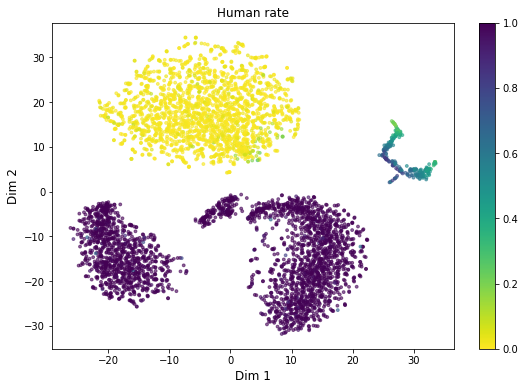

In [12]:
cluster_df=pd.read_table(snap_cluster)
bc_hgrate=get_hg_rate(atac_bed)
map_human_rate(cluster_df,bc_hgrate,prefix)

/Share2/home/zhangqf5/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Share2/home/zhangqf5/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3049: RuntimeWarning: invalid value encountered in double_scalars
  0.5*df, 0.5, np.fmin(np.asarray(df / (df + t_squared)), 1.0)


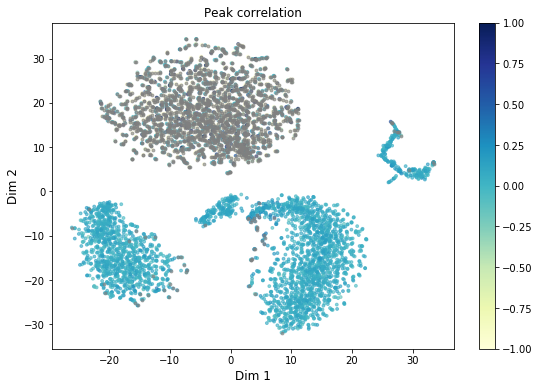

In [15]:
peak_cor,NA_bc=get_peak_cor(ref_peak_counts_dict,bc_peak_count_dict)
map_peak_cor(cluster_df,peak_cor,prefix,NA_bc)

In [22]:
def get_cluster_cor(bc_cluster, peaks, ref_peak_counts_dict, bc_peak_count_dict):
    # get correlation for specified barcodes and peaks
    cluster_peak_count=[]
    ref_peak_count=[]
    for peak in peaks:
        peak_count=0
        for bc in bc_cluster:           
            try:
                peak_count+=bc_peak_count_dict[(bc,peak)]
            except:
                pass
        cluster_peak_count.append(peak_count)
        ref_peak_count.append(ref_peak_counts_dict[peak])
    l1=np.log2(np.array(cluster_peak_count)+1)
    l2=np.log2(np.array(ref_peak_count)+1)
    cor=scipy.stats.pearsonr(l1, l2)
    print(cor)
    plt.figure(figsize=(6,6))
    plt.scatter(l1, l2, s=4,alpha=0.6)
    plt.text( 1, max(l2)*0.95,'cor=%.2f\np=%.4f'%cor)
    plt.xlabel('log2 cluster_peak_count')
    plt.ylabel('log2 ref_peak_count')
    return cor

In [19]:
classes=cluster_df['cluster'].unique()

In [20]:
classes

array([ 5, 10,  4,  9,  6,  7,  2,  3,  8,  1])

Cluster  5
(0.8140530056365364, 0.0)
Cluster  10
(0.14603419279720883, 1.3111630189569496e-10)
Cluster  4
(0.6102082977344686, 0.0)
Cluster  9
(0.6275159357161193, 0.0)
Cluster  6
(0.806200664818857, 0.0)
Cluster  7
(0.1418904629900034, 8.008216639305979e-10)
Cluster  2
(0.7271229973461326, 0.0)
Cluster  3
(0.7289155558817377, 0.0)
Cluster  8
(0.7048770609879184, 0.0)
Cluster  1
(0.3499158540290663, 1.124441217e-315)


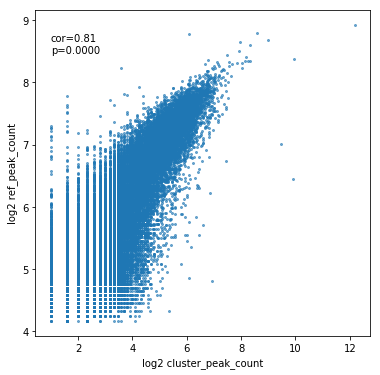

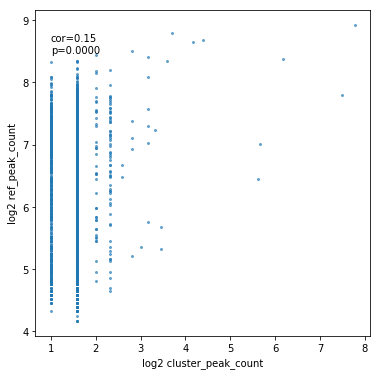

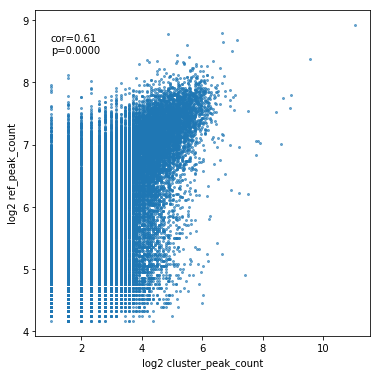

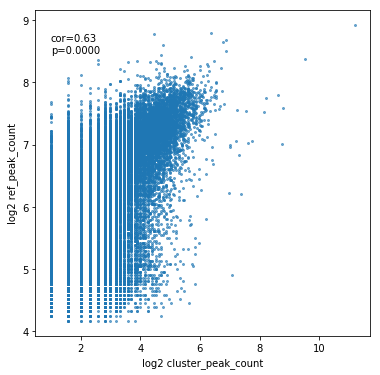

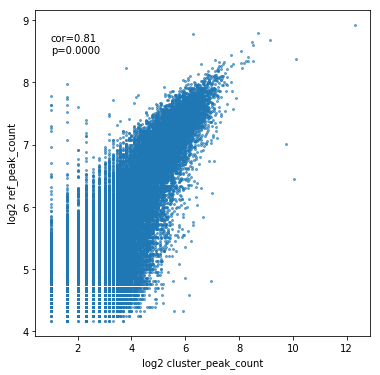

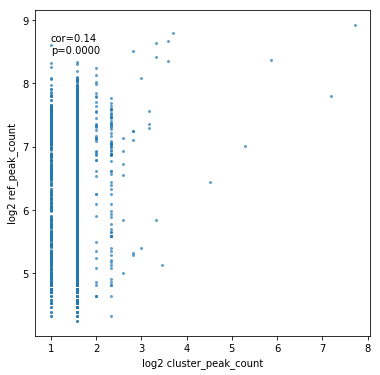

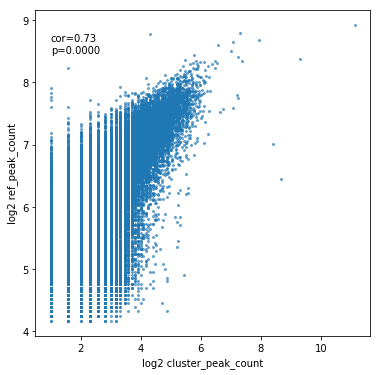

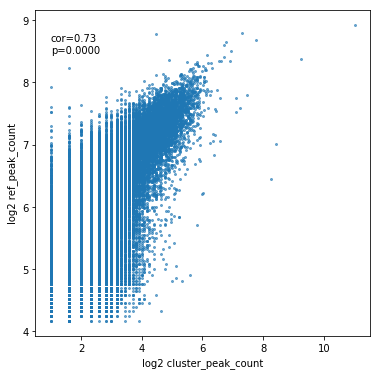

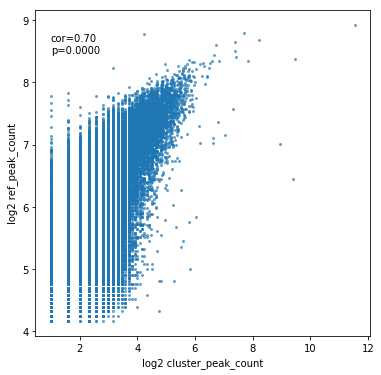

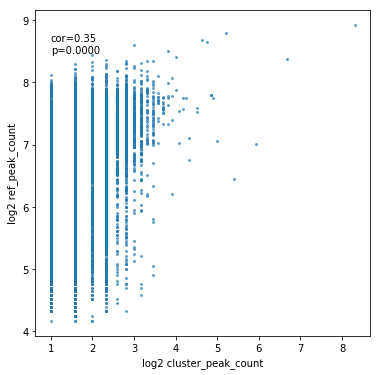

In [23]:
for cls in classes:
    bc_set=cluster_df[cluster_df['cluster']==cls]['barcodes']
    peak_set=inter_peak[inter_peak['barcode'].isin(bc_set)]['peak'].unique()
    print('Cluster ', cls)
    cor=get_cluster_cor(bc_set, peak_set, ref_peak_counts_dict, bc_peak_count_dict)
    cluster_df.loc[cluster_df['cluster']==cls,'peak_cor']=cor[0]

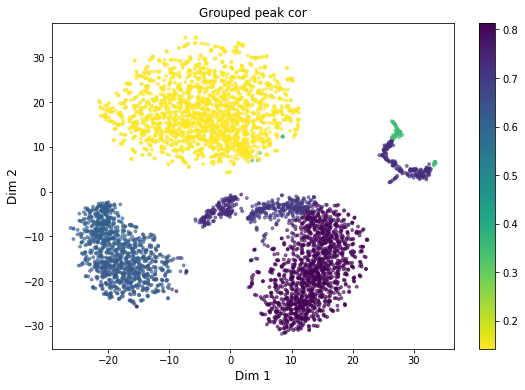

In [24]:
plot_map(cluster_df['tsne.1'],cluster_df['tsne.2'],cluster_df['peak_cor'],'Grouped peak cor','Grouped_peak_cor.pdf')

# combine ATAC and RNA matrix

In [2]:
from scipy.io import mmread

In [36]:
change={'GTACATGT':'0F3','GTTGCAAC':'0F5','TAATTGAG':'0F7','TAGGTTGT':'0F9','TATGGTAG':'F10', 'GTGCGTAG':'F4T', 'GTTAACCT':'F4B', 'TATGTGTC':'F40',
        '0000F5R.':'0F5','0000F7R.':'0F7','0000F9R.':'0F9','000F10R.':'F10',
       '000F5RF.':'0F5','000F7RF.':'0F7','000F9RF.':'0F9','00F10RF.':'F10'}
# connect atac and rna cells

In [4]:
# read rna
def read_genemtx(mf,rf,cf):
    matrix=mmread(mf)
    barcodes=pd.read_csv(rf)['cell_barcode'].apply(lambda x: change[x.split('_')[1][:8]]+x.split('_')[1][8:])
    genes=pd.read_csv(cf)['gene_id']
    M = matrix.todense()
    df = pd.DataFrame(M, barcodes.values, genes.values)
    return df

In [5]:
sample="ZJS190905_R"
indir='/Share2/home/zhangqf5/yanqiu/scAR/output/'+sample
rnadf=pd.DataFrame()
for s in ['F10R','F9R','F5R','F7R']:
    rna=read_genemtx('%s/DGE_filtered/%s_RNA_DGE.mtx'%(indir,s),
                     '%s/DGE_filtered/%s_RNA_cell_metadata.csv'%(indir,s),
                     '%s/DGE_filtered/%s_RNA_genes.csv'%(indir,s))
    rnadf = rnadf.append(rna)

/Share2/home/zhangqf5/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Share2/home/zhangqf5/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Share2/home/zhangqf5/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retai

In [22]:
def read_atacmtx(mf,rf,cf):
    matrix=mmread(mf)
    barcodes=pd.read_csv(rf, sep='\t')['x'].apply(lambda x: change[x.split('_')[1][:8]]+x.split('_')[1][8:])
    genes=pd.read_csv(cf, sep='\t')['name']
    M = matrix.todense()
    df = pd.DataFrame(M, barcodes.values, genes.values)
    return df

In [23]:
sample_atac='ZJS190808'
indir='/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS190808_A'
method='pmat_jda'
atacdf=read_atacmtx('%s/snapatac/%s_%s_sparseM.txt'%(indir,sample_atac,method),
                   '%s/snapatac/%s_%s_barcodes.txt'%(indir,sample_atac,method),
                   '%s/snapatac/%s_%s_peaks.txt'%(indir,sample_atac,method))

In [25]:
sample_atac='ZJS190808'
indir='/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS190808_A'
method='bmat_jda'
atacdf2=read_atacmtx('%s/snapatac/%s_%s_sparseM.txt'%(indir,sample_atac,method),
                   '%s/snapatac/%s_%s_barcodes.txt'%(indir,sample_atac,method),
                   '%s/snapatac/%s_%s_bins.txt'%(indir,sample_atac,method))

In [26]:
print(rnadf.shape,atacdf.shape,atacdf2.shape)

(2157, 38929) (2253, 39409) (2242, 550747)


In [27]:
rnadf=rnadf.fillna(0).astype('int')

In [28]:
from scipy.io import mmwrite
from scipy.sparse import csr_matrix
def write_mtx(df, path):
    mmwrite(path+'/count.mtx', csr_matrix(df))
    np.savetxt(path+'/barcodes.txt',df.columns.values,fmt="%s")
    np.savetxt(path+'/peaks.txt',df.index.values,fmt="%s")

In [31]:
write_mtx(rnadf.T, indir+'/combine/RNA')
write_mtx(atacdf.T, indir+'/combine/ATAC_pm')
write_mtx(atacdf2.T, indir+'/combine/ATAC_bm')

In [12]:
overlap_bc=[bc for bc in rnadf.index if bc in atacdf.index]

In [13]:
atac_i=atacdf.loc[overlap_bc,:]
rna_i=rnadf.loc[overlap_bc,:]

In [14]:
rna_i=rna_i.fillna(0).astype('int')

In [15]:
print(atac_i.shape,rna_i.shape)

(2056, 40177) (2056, 38929)


In [16]:
atac_i.iloc[0:5,0:5]

,hg_GL000009.2:124603-125103,hg_GL000194.1:114750-115250,hg_GL000195.1:30564-31064,hg_GL000195.1:32250-32750,hg_GL000195.1:86463-86963
F10AACGTCGCGCCGCTAAACCGCA,0,0,0,0,2
F10AACGTCGCTCCAGCTTCCACGT,0,0,0,1,0
F10AAGGAGCTGTACCTGTACCGCA,0,0,0,0,0
F10AATACCGCGTTATTGGAACAAC,0,0,0,0,0
F10ACAACTTCACTCCGAAAACAAC,0,0,0,0,0


In [17]:
rna_i.iloc[0:5,0:5]

,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15
F10AACGTCGCGCCGCTAAACCGCA,0,0,1,0,0
F10AACGTCGCTCCAGCTTCCACGT,0,0,0,0,0
F10AAGGAGCTGTACCTGTACCGCA,0,0,0,0,0
F10AATACCGCGTTATTGGAACAAC,0,0,0,0,0
F10ACAACTTCACTCCGAAAACAAC,0,0,0,0,0


In [169]:
fmax_gene=0.9
fmin_gene=0.02
fmax_peak=0.9
fmin_peak=0.02

In [170]:
def filter(df,maxf,minf):
    df=df.fillna(0).astype('int')
    featureratio = df[df >= 1].count(axis=0)/df.shape[0]
    featuref=(featureratio[(featureratio>minf)&(featureratio<maxf)]).index
    df=df.loc[:,featuref]
    return df  

In [185]:
rna=filter(rna_i,fmax_gene,fmin_gene)
atac=filter(atac_i,fmax_peak,fmin_peak)
print(atac.shape,rna.shape)

(1980, 9971) (1980, 13137)


In [173]:
atac.T.to_csv('peak_count.txt',index=True,sep='\t')
rna.T.to_csv('gene_count.txt',index=True,sep='\t')

In [155]:
# get gene fpkm
import pickle
with open('/Share2/home/zhangqf5/yanqiu/scAR_old/split_seq/split-seq-pipeline/INDEX_mm_hg/gene_info.pkl', 'rb') as f:
    geneinfo = pickle.load(f)
gene_len={}
for gene in geneinfo['gene_starts']:
    gene_len[gene]=geneinfo['gene_ends'][gene]-geneinfo['gene_starts'][gene]+1

In [181]:
genecounts=rna.T
genelen=np.array([gene_len[gene] for gene in genecounts.index])
fpkm=pd.DataFrame()
for bc in genecounts.columns:
    fpkm[bc]=genecounts[bc]/sum(rna.T[bc])/genelen*10**9

In [183]:
fpkm.to_csv('gene_rpkm.txt',index=True,sep='\t')

# cor R vs RF

In [37]:
sample="ZJS190905_RF"
indir='/Share2/home/zhangqf5/yanqiu/scAR/output/'+sample
rnadf2=pd.DataFrame()
for s in ['F10RF','F9RF','F5RF','F7RF']:
    rna2=read_genemtx('%s/DGE_filtered/%s_RNA_DGE.mtx'%(indir,s),
                     '%s/DGE_filtered/%s_RNA_cell_metadata.csv'%(indir,s),
                     '%s/DGE_filtered/%s_RNA_genes.csv'%(indir,s))
    rnadf2 = rnadf.append(rna)

/Share2/home/zhangqf5/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Share2/home/zhangqf5/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Share2/home/zhangqf5/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retai

In [38]:
rnadf2=rnadf2.fillna(0).astype('int')

In [39]:
print(rnadf.shape, rnadf2.shape)

(2157, 38929) (2910, 38929)


In [41]:
rnadf.iloc[0:5,0:5]

,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15
F10AACGTCGCGCCGCTAAACCGCA,0,0,1,0,0
F10AACGTCGCTCCAGCTTCCACGT,0,0,0,0,0
F10AAGGAGCTGTACCTGTACCGCA,0,0,0,0,0
F10AATACCGCGTTATTGGAACAAC,0,0,0,0,0
F10ACAACTTCACTCCGAAAACAAC,0,0,0,0,0


In [42]:
rnadf2.iloc[0:5,0:5]

,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15
F10AACGTCGCGCCGCTAAACCGCA,0,0,1,0,0
F10AACGTCGCTCCAGCTTCCACGT,0,0,0,0,0
F10AAGGAGCTGTACCTGTACCGCA,0,0,0,0,0
F10AATACCGCGTTATTGGAACAAC,0,0,0,0,0
F10ACAACTTCACTCCGAAAACAAC,0,0,0,0,0


In [43]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

In [44]:
import pickle
gene_info = pickle.load(open('/Share2/home/zhangqf5/yanqiu/scAR_old/split_seq/split-seq-pipeline/INDEX_mm_hg/gene_info.pkl', 'rb'))


In [45]:
gene_info.keys()

dict_keys(['gene_bins', 'genes_to_exons', 'gene_starts', 'gene_ends', 'gene_id_to_name', 'gene_id_to_genome', 'gene_id_to_chrom', 'gene_id_to_strand', 'gene_id_to_biotype'])

In [46]:
gene_length={}
for gene in gene_info['gene_starts'].keys():
    gene_length[gene]=gene_info['gene_ends'][gene]-gene_info['gene_starts'][gene]

In [49]:
def get_rpkm(gene_length,count,genes):
    count=np.array(count)
    length=np.array([gene_length[gene] for gene in genes])
    total=sum(count)
    rpkm=count/(length/1000* total/1000000)
    return rpkm

In [65]:
def cor_R_RF(tag):
    indir1='/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS190905_R'
    rna1=read_genemtx('%s/DGE_filtered/%sR_RNA_DGE.mtx'%(indir1,tag),
                     '%s/DGE_filtered/%sR_RNA_cell_metadata.csv'%(indir1,tag),
                     '%s/DGE_filtered/%sR_RNA_genes.csv'%(indir1,tag))
    indir2='/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS190905_RF'
    rna2=read_genemtx('%s/DGE_filtered/%sRF_RNA_DGE.mtx'%(indir2,tag),
                     '%s/DGE_filtered/%sRF_RNA_cell_metadata.csv'%(indir2,tag),
                     '%s/DGE_filtered/%sRF_RNA_genes.csv'%(indir2,tag))
    overlap_bc=[bc for bc in rna1.columns if bc in rna2.columns]
    rna1=rna1[overlap_bc]
    rna2=rna2[overlap_bc]
    rpkm1=get_rpkm(gene_length, rna1.sum(axis=0), rna1.columns)
    rpkm2=get_rpkm(gene_length, rna2.sum(axis=0), rna2.columns)
    cor=scipy.stats.pearsonr(rpkm1, rpkm2)
    plt.figure(figsize=(6,6))
    plt.scatter(np.log2(rpkm1+1), np.log2(rpkm2+1), alpha=0.5,s=4)
    plt.show()
    print(cor)
    return rpkm1, rpkm2, cor

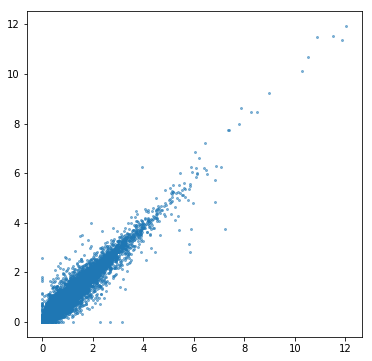

(0.9743906516740724, 0.0)


In [68]:
rpkm1, rpkm2, cor=cor_R_RF('F5')

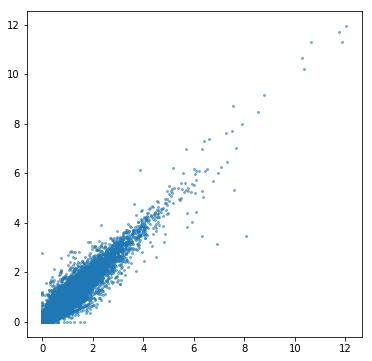

(0.9726920618450035, 0.0)


In [66]:
rpkm1, rpkm2, cor=cor_R_RF('F7')

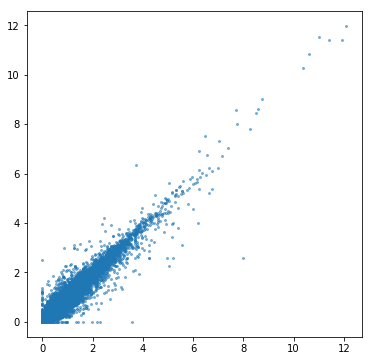

(0.9761364987485741, 0.0)


In [69]:
rpkm1, rpkm2, cor=cor_R_RF('F9')

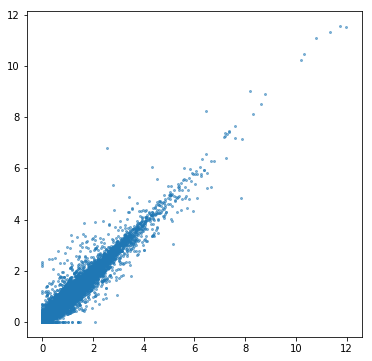

(0.9827152296871906, 0.0)


In [70]:
rpkm1, rpkm2, cor=cor_R_RF('F10')

# bw analysis

In [4]:
import pyBigWig

In [5]:
from numpy import mean

In [ ]:
import matplotlib.pyplot as plt

In [6]:
bw = pyBigWig.open("/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS190905_R/mapping/F5R_RNA.mapped.sorted.bw")

In [124]:
mean(bw.values('hg_chr1', 89294, 89295))

0.0

In [75]:
gene_id_to_chrom=gene_info['gene_id_to_chrom']
gene_starts=gene_info['gene_starts']
gene_ends=gene_info['gene_ends']
gene_strands=gene_info['gene_id_to_strand']

In [102]:
list(gene_strands.keys())[:5]

['ENSMUSG00000102693.1',
 'ENSMUSG00000064842.1',
 'ENSMUSG00000051951.5',
 'ENSMUSG00000102851.1',
 'ENSMUSG00000103377.1']

In [78]:
genes=rnadf.columns

In [103]:
genes[:4]

Index(['ENSG00000000419.12', 'ENSG00000000457.13', 'ENSG00000000460.16',
       'ENSG00000000938.12'],
      dtype='object')

In [125]:
def gene_coverage(gene, bw, bin_num):
    bin_cover=np.zeros(bin_num)
    chrom=gene_id_to_chrom[gene]
    end=gene_ends[gene]
    start=gene_starts[gene]
    strand=gene_strands[gene]
    if end-start>100:
        bin_len=(end-start)/bin_num
        bins=[int(start+ bin_len*i) for i in range(bin_num+1)]
        bin_cover=[mean(bw.values(chrom, bins[i], bins[i+1])) for i in range(bin_num)]
        if strand=='-':
            bin_cover=bin_cover[::-1]
    return bin_cover

In [126]:
bin_num=100
coverage_overall=np.zeros(bin_num)
for gene in genes:
    bin_cover=gene_coverage(gene, bw, 100)
    coverage_overall=coverage_overall+bin_cover    

In [128]:
gene

'ENSMUSG00000112929.1'

In [129]:
list(genes).index(gene)

38928

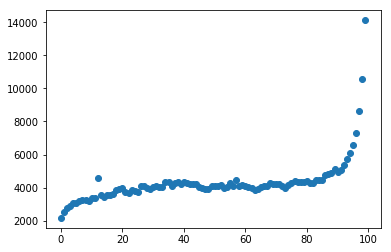

In [118]:
plt.scatter(range(bin_num), coverage_overall)

In [114]:
print (gene)

ENSG00000200917.1


In [120]:
print (gene_starts[gene], gene_ends[gene])

105406997 105407092


In [117]:
list(genes).index(gene)

13668

In [121]:
chrom=gene_id_to_chrom[gene]
end=gene_ends[gene]
start=gene_starts[gene]
strand=gene_strands[gene]
bin_len=(end-start)/bin_num
bins=[int(start+ bin_len*i) for i in range(bin_num+1)]

In [9]:
from bin_coverage import bin_coverage
import pickle
gene_info = pickle.load(open('/Share2/home/zhangqf5/yanqiu/scAR_old/split_seq/split-seq-pipeline/INDEX_mm_hg/gene_info.pkl', 'rb'))
genes=pd.read_csv("/Share2/home/zhangqf5/yanqiu/scAR/output/ZJS190905_R/DGE_filtered/F5R_RNA_genes.csv")['gene_id']

In [31]:
def bin_coverage(gene_info, genes, bw, bin_num):
    gene_id_to_chrom=gene_info['gene_id_to_chrom']
    gene_starts=gene_info['gene_starts']
    gene_ends=gene_info['gene_ends']
    gene_strands=gene_info['gene_id_to_strand']
    def gene_cov(gene):
        bin_cover=np.zeros(bin_num)
        chrom=gene_id_to_chrom[gene]
        end=gene_ends[gene]
        start=gene_starts[gene]
        strand=gene_strands[gene]
        mean_gene_cov=mean(bw.values(chrom, start, end))
        if end-start>bin_num and mean_gene_cov>0:         
            bin_len=(end-start)/bin_num
            bins=[int(start+ bin_len*i) for i in range(bin_num+1)]
            bin_cover=[mean(bw.values(chrom, bins[i], bins[i+1]))/mean_gene_cov for i in range(bin_num)]
            if strand=='-':
                bin_cover=bin_cover[::-1]
        return np.array(bin_cover)
    '''
    coverage_overall=np.zeros(bin_num)
    for gene in genes:
        bin_cover=gene_coverage(gene, bw, bin_num)
        coverage_overall=coverage_overall+bin_cover
    '''
    coverage_overall=[]
    for gene in genes:
        bin_cover=gene_cov(gene)
        coverage_overall.append(bin_cover)
    coverage_overall=pd.DataFrame(coverage_overall, index=genes)
    return coverage_overall

In [14]:
%matplotlib inline

In [21]:
bin_num=100
cov=bin_coverage(gene_info, genes[:10000], bw, bin_num)

In [25]:
hgenes=[]
for gene in genes:
        if gene.startswith('ENSG'):
            hgenes.append(gene)

In [32]:
cov_hg=bin_coverage(gene_info, hgenes[13000:], bw, bin_num)

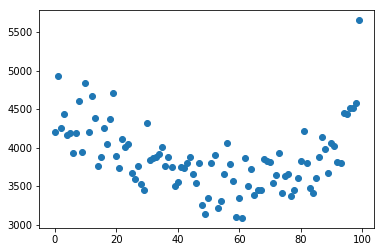

In [33]:
plt.scatter(range(bin_num), cov_hg.sum(axis=0))